In [342]:


def grid_simulate(atr=0.01, zone_height=0.01, tp_size=0.01, rounds=100, debug=False):
    """
    atr = daily return (volaitlity proxy)
    """
    base_price = 1
    starting_price = base_price * (atr + 1) ** (0)
    import math
    zone_count = math.log((1+atr), (1+zone_height))
    position_size = min(1, 1 / zone_count)
    
    if debug:
        print('zone count {:.4f}'.format(zone_count))
        print('position size {:.4f}'.format(position_size))
    
    ## generate price sequence
    import random
    sequence = [random.randint(0,1) for i in range(rounds)]
    prices = [starting_price]
    current_price = starting_price
    for direction in sequence:
        if direction == 1:
            current_price = current_price * (1+atr)
        else:
            current_price = current_price / (1+atr)
            
        prices.append(current_price)
        
    ## simulate position
    positions = {}
    import heapq
    position_heap = []
    profit = 0
    hit = 0
    shoot = 0
    durations = []
    for index in range(len(prices)-1):
        price0 = prices[index]
        price1 = prices[index+1]
        
        
        import math
        zone0 = math.floor(math.log(price0 / base_price, (1+zone_height)))
        zone1 = math.floor(math.log(price1 / base_price, (1+zone_height)))
        
        if debug:
            print('move {} {} - {:.3f} {:.3f}'.format(
                  zone0,
                  zone1,
                  math.log(price0 / base_price, (1+zone_height)),
                  math.log(price1 / base_price, (1+zone_height))
            ))
        
        for passing_zone in range(min(zone0, zone1), max(zone0, zone1)+1):
            if positions.get(passing_zone, None) is None:
                positions[passing_zone] = index
                heapq.heappush(position_heap, passing_zone)
                shoot += 1

        if zone0 < zone1:
            # up move
            zone_price = price1
            while len(position_heap) > 0:
                position_zone = position_heap[0]
            # for position_zone in list(positions.keys()):
                cost_price = base_price * (1+zone_height) ** position_zone
                if zone_price >= cost_price * (1+tp_size):
                    open_time = positions[position_zone]
                    positions.pop(position_zone)
                    heapq.heappop(position_heap)
                    hit += 1
                    position_profit = position_size * tp_size
                    profit += position_profit
                    durations.append(index - open_time)
                    if debug:
                        print('{:4d} take profit {} -> {:.2f}: +{:.6f} = {:.6f}'.format(
                            index,
                            position_zone,
                            math.log(cost_price * (1+tp_size) / base_price, (1+zone_height)),
                            position_profit,
                            profit
                        ))
                else:
                    break

        
                    
    import numpy
    duration = numpy.mean(durations)
                
    result = {
        'profit': profit/rounds,
        'hit_rate': hit/rounds,
        'duration': duration,
    }
        
    return result

atr = 0.01
ratio = 100
height = (atr+1)**ratio-1
grid_simulate(zone_height=height, debug=False)

/home/piyawut/code/tools2/venv/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/piyawut/code/tools2/venv/lib/python3.5/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


{'duration': nan, 'hit_rate': 0.0, 'profit': 0.0}

In [344]:


def one_round(config):
    return grid_simulate(atr=config[0], zone_height=config[1], tp_size=config[2], rounds=1000)

def grid_stat(atr, zone_height, tp_size):
    import numpy
    import multiprocessing
    pool = multiprocessing.Pool(40)
    
    try:
        results = pool.map(one_round, [(atr, zone_height, tp_size) for i in range(1000)])
        # results = [grid_simulate(atr, zone_height) for times in range(10000)]
    finally:
        pool.close()
        pool = None
    hit_rate = numpy.median([item['hit_rate'] for item in results])
    profit = numpy.median([item['profit'] for item in results])
    duration = numpy.median([item['duration'] for item in results])
    result = {
        'hit_rate': hit_rate,
        'profit': profit,
        'duration': duration,
    }
    return result



rows = []
atr = 0.01
for zone_ratio in [((1.01)**10) ** index for index in range(-18, 36, 2)]:
    for tp_ratio in [((1.01)**10) ** index for index in range(-18, 36, 2)]:
        print('{:.2f} {:.2f}'.format(zone_ratio, tp_ratio))
        zone_height = (atr+1) ** zone_ratio - 1
        tp_size = (atr+1) ** tp_ratio - 1

        result = grid_stat(atr, zone_height, tp_size)
        row = {
            'ratio': zone_height / atr,
            'tp_size': tp_size / atr,
            'hit_rate': result['hit_rate'],
            'profit': result['profit'],
            'duration': result['duration'],
        }
        rows.append(row)
    
    
import csv
with open('grid_hit_rate.csv', 'w') as f:
    writer = csv.DictWriter(f, fieldnames=['ratio', 'tp_size', 'profit', 'hit_rate', 'duration'])
    writer.writeheader()
    for row in rows:
        writer.writerow(row)

    


0.17 0.17
0.17 0.20
0.17 0.25
0.17 0.30
0.17 0.37
0.17 0.45
0.17 0.55
0.17 0.67
0.17 0.82
0.17 1.00
0.17 1.22
0.17 1.49
0.17 1.82
0.17 2.22
0.17 2.70
0.17 3.30
0.17 4.03
0.17 4.91
0.17 6.00
0.17 7.32
0.17 8.93
0.17 10.89
0.17 13.29


/home/piyawut/code/tools2/venv/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/piyawut/code/tools2/venv/lib/python3.5/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/piyawut/code/tools2/venv/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/piyawut/code/tools2/venv/lib/python3.5/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/piyawut/code/tools2/venv/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/piyawut/code/tools2/venv/lib/python3.5/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/hom

0.17 16.22


/home/piyawut/code/tools2/venv/lib/python3.5/site-packages/numpy/lib/function_base.py:4033: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)
/home/piyawut/code/tools2/venv/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/piyawut/code/tools2/venv/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/piyawut/code/tools2/venv/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/piyawut/code/tools2/venv/lib/python3.5/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/piyawut/code/tools2/venv/lib/python3.5/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/piyawut/code/

0.17 19.79


/home/piyawut/code/tools2/venv/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/piyawut/code/tools2/venv/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/piyawut/code/tools2/venv/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/piyawut/code/tools2/venv/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/piyawut/code/tools2/venv/lib/python3.5/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/piyawut/code/tools2/venv/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/piyawut/code/tools2/venv/lib/python3.5/site-packages/numpy/core/_m

limit_output extension: Maximum message size of 10000 exceeded with 10050 characters

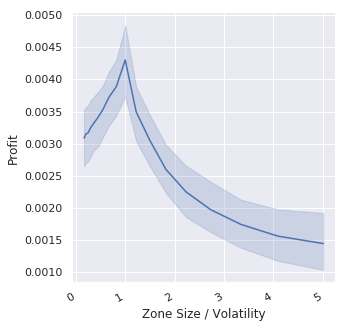

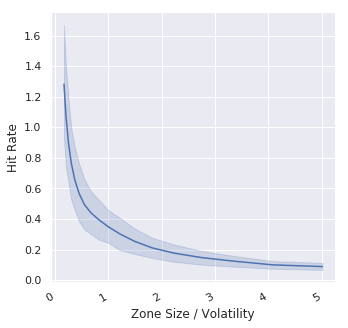

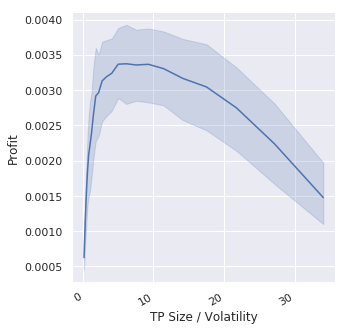

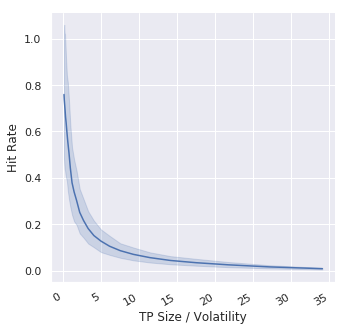

In [361]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

df = pd.DataFrame(dict(
        time=[row['ratio'] for row in rows if row['ratio'] < 6],
        value=[row['profit'] for row in rows if row['ratio'] < 6]
))
g = sns.relplot(x="time", y="value", kind="line", data=df)
g.set_axis_labels("Zone Size / Volatility", "Profit")
g.fig.autofmt_xdate()


df = pd.DataFrame(dict(
        time=[row['ratio'] for row in rows if row['ratio'] < 6],
        value=[row['hit_rate'] for row in rows if row['ratio'] < 6]
))
g = sns.relplot(x="time", y="value", kind="line", data=df)
g.set_axis_labels("Zone Size / Volatility", "Hit Rate")
g.fig.autofmt_xdate()

df = pd.DataFrame({
        'tp_size': [row['tp_size'] for row in rows],
        'profit': [row['profit'] for row in rows]
})
g = sns.relplot(x="tp_size", y="profit", kind="line", data=df)
g.set_axis_labels("TP Size / Volatility", "Profit")
g.fig.autofmt_xdate()

df = pd.DataFrame(dict(
        time=[row['tp_size'] for row in rows],
        value=[row['hit_rate'] for row in rows]
))
g = sns.relplot(x="time", y="value", kind="line", data=df)
g.set_axis_labels("TP Size / Volatility", "Hit Rate")
g.fig.autofmt_xdate()

Profit vs Zone Size vs TP Size


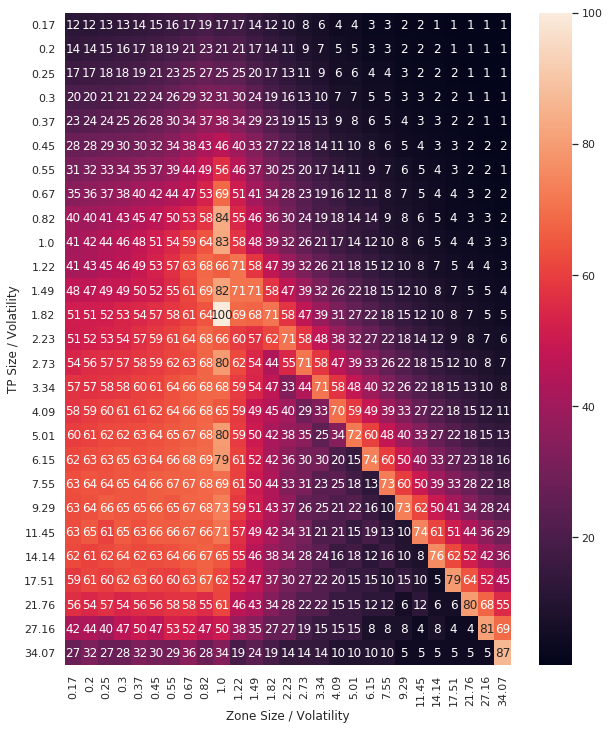

In [346]:
import math

print('Profit vs Zone Size vs TP Size')

ratio = [round(row['ratio'], 2) for row in rows]
tp_size = [round(row['tp_size'], 2) for row in rows]
maxprofit = max([row['profit'] for row in rows])
profit = [row['profit'] / maxprofit * 100 for row in rows]
d = pd.DataFrame({
    'Zone Size / Volatility':ratio,
    'TP Size / Volatility':tp_size,
    'Profit':profit,
})
d = d.pivot('TP Size / Volatility', 'Zone Size / Volatility', 'Profit')

import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10,12)) 
ax = sns.heatmap(d, annot=True, fmt='.0f')